In [1]:
import numpy as np
import numpy.linalg as npla
from scipy.io import loadmat
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib widget
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
        "font.size": 14,
    }
)

from pysteam import evaluable, problem, solver
from pysteam.evaluable import vspace

In [2]:
data = loadmat("dataset2.mat")
x_true = np.concatenate((data["x_true"], data["y_true"], data["th_true"]), axis=1)[
    ..., None
]  # (N, 3, 1)
K = x_true.shape[0]  # 12609
dt = 0.1  # sampling period
t = data["t"]  # timestamps (K, 1)
# motion
v = np.concatenate((data["v"], data["om"]), axis=1)[..., None]  # (N, 2, 1)
v_cov = (
    np.array([[data["v_var"][0, 0], 0.0], [0.0, data["om_var"][0, 0]]]) * 10.0
)  # (2, 2)
# observation
l = data["l"][..., None]  # ground truth landmark location (17, 2, 1)
d = data["d"][0, 0]  # distance b/t robot center & laser range finder
rmax = 5.0  # maximum range
r = data["r"][..., None, None]  # range measurement (K, 17, 1, 1)
b = data["b"][..., None, None]  # bearing measurement (K, 17, 1, 1)
y = np.concatenate((r, b), axis=2)  # (K, 17, 2, 1)
r_var = data["r_var"][0, 0]  # variance of range measurement
b_var = data["b_var"][0, 0]  # bearing measurement variance
r_cov = np.array([[r_var, 0.0], [0.0, b_var]])
# initial state
x0 = x_true[0]
x0_cov = np.diag((1, 1, 0.1))

In [3]:
class MotionNoise(problem.NoiseEvaluator):
    def __init__(self, x, v_cov, dt):
        super().__init__()
        self._x = x
        self._dt = dt
        self._v_cov = v_cov

    @staticmethod
    def W(x, dt):
        return dt * np.array([[np.cos(x[2, 0]), 0], [np.sin(x[2, 0]), 0], [0, 1]])

    def evaluate(self):
        x = self._x.evaluate()
        return (
            self.W(x, dt) @ self._v_cov @ self.W(x, dt).T + np.eye(3) * 1e-6
        )  # add small noise to avoid singularity


class MotionError(evaluable.Evaluable):
    def __init__(self, xk, xkm1, vk, dt):
        super().__init__()
        self._xk = xk
        self._xkm1 = xkm1
        self._vk = vk
        self._dt = dt

    @staticmethod
    def f(xkm1, vk, dt):
        tmp = np.array([[np.cos(xkm1[2, 0]), 0], [np.sin(xkm1[2, 0]), 0], [0, 1]])
        return xkm1 + dt * tmp @ vk

    @staticmethod
    def F(xkm1, vk, dt):
        return np.array(
            [
                [1.0, 0.0, -dt * np.sin(xkm1[2, 0]) * vk[0, 0]],
                [0.0, 1.0, dt * np.cos(xkm1[2, 0]) * vk[0, 0]],
                [0.0, 0.0, 1.0],
            ]
        )

    @property
    def active(self) -> bool:
        return self._xk.active or self._xkm1.active

    @property
    def related_var_keys(self) -> set:
        return self._xk.related_var_keys | self._xkm1.related_var_keys

    def forward(self):
        xkm1 = self._xkm1.forward()
        xk = self._xk.forward()
        error = self.f(xkm1.value, self._vk, self._dt) - xk.value
        return evaluable.Node(error, xk, xkm1)

    def backward(self, lhs, node, jacs) -> None:
        if self._xk.active:
            self._xk.backward(-lhs, node.children[0], jacs)
        if self._xkm1.active:
            child = node.children[1]
            self._xkm1.backward(
                lhs @ self.F(child.value, self._vk, self._dt), child, jacs
            )


class ObservationNoise(problem.NoiseEvaluator):
    def __init__(self, r_cov):
        self._r_cov = r_cov

    @staticmethod
    def W():
        return np.eye(2)

    def evaluate(self):
        return self._r_cov


class ObservationError(evaluable.Evaluable):
    def __init__(self, x, y, d, l):
        super().__init__()
        self._x = x  # state (3, 1)
        self._y = y  # range bearing (2, 1)
        self._d = d  # scalar distance b/t robot center & laser range finder
        self._l = l  # landmark location (2, 1)
        self._wrap_to_pi = lambda th: (th + np.pi) % (2 * np.pi) - np.pi

    @staticmethod
    def g(xk, d, l):
        x, y, th = xk[0, 0], xk[1, 0], xk[2, 0]
        lx, ly = l[0, 0], l[1, 0]

        dx = lx - x - d * np.cos(th)
        dy = ly - y - d * np.sin(th)
        return np.array([[np.sqrt(dx**2 + dy**2)], [np.arctan2(dy, dx) - th]])

    @staticmethod
    def G(xk, d, l):
        x, y, th = xk[0, 0], xk[1, 0], xk[2, 0]
        lx, ly = l[0, 0], l[1, 0]

        dx = lx - x - d * np.cos(th)
        dy = ly - y - d * np.sin(th)

        dgldx = np.array(
            [[-((dx**2 + dy**2) ** (-1 / 2)) * dx], [dy / (dx**2 + dy**2)]]
        )
        dgldy = np.array(
            [[-((dx**2 + dy**2) ** (-1 / 2)) * dy], [-dx / (dx**2 + dy**2)]]
        )
        dgldth = np.array(
            [
                [
                    (dx**2 + dy**2) ** (-1 / 2)
                    * (dx * d * np.sin(th) - dy * d * np.cos(th))
                ],
                [
                    -(dx * d * np.cos(th) + dy * d * np.sin(th)) / (dx**2 + dy**2)
                    - 1
                ],
            ]
        )
        return np.concatenate((dgldx, dgldy, dgldth), axis=1)

    @property
    def active(self) -> bool:
        return self._x.active

    @property
    def related_var_keys(self) -> set:
        return self._x.related_var_keys

    def forward(self):
        child = self._x.forward()
        gl = self.g(child.value, self._d, self._l)
        error = self._y - gl
        error[1, 0] = self._wrap_to_pi(error[1, 0])
        return evaluable.Node(error, child)

    def backward(self, lhs, node, jacs) -> None:
        if self._x.active:
            child = node.children[0]
            Gl = self.G(child.value, self._d, self._l)
            self._x.backward(-lhs @ Gl, child, jacs)

In [4]:
def plot(t, x_hat, x_std_hat, x_true):
    t = t.squeeze()
    error = (x_true - x_hat).squeeze()
    error[:, 2] = wrap_to_pi(error[:, 2])
    x_std_hat = x_std_hat.squeeze()
    print("average e^2:", np.mean(np.square(error), axis=0).flatten())

    fig = plt.figure(figsize=(25, 18))

    ax = fig.add_subplot(311)
    ax.plot(t, error[:, 0], linewidth=1.0)
    ax.plot(t, -3 * x_std_hat[:, 0], "r--", linewidth=1.0)
    ax.plot(t, +3 * x_std_hat[:, 0], "g--", linewidth=1.0)
    ax.fill_between(t, -3 * x_std_hat[:, 0], 3 * x_std_hat[:, 0], alpha=0.2)
    ax.set_ylabel(r"$x$ [$m$]")
    ax.set_title("Error")

    ax = fig.add_subplot(312)
    ax.plot(t, error[:, 1], linewidth=1.0)
    ax.plot(t, -3 * x_std_hat[:, 1], "r--", linewidth=1.0)
    ax.plot(t, +3 * x_std_hat[:, 1], "g--", linewidth=1.0)
    ax.fill_between(t, -3 * x_std_hat[:, 1], 3 * x_std_hat[:, 1], alpha=0.2)
    ax.set_ylabel(r"$y$ [$m$]")

    ax = fig.add_subplot(313)
    ax.plot(t, error[:, 2], linewidth=1.0)
    ax.plot(t, -3 * x_std_hat[:, 2], "r--", linewidth=1.0)
    ax.plot(t, +3 * x_std_hat[:, 2], "g--", linewidth=1.0)
    ax.fill_between(t, -3 * x_std_hat[:, 2], 3 * x_std_hat[:, 2], alpha=0.2)
    ax.set_ylabel(r"$\theta$ [$m$]")
    ax.set_xlabel(r"$t$ [$s$]")

    plt.show()

## Standard Extended Kalman Filter

average e^2: [0.00149973 0.00222039 0.00096768]


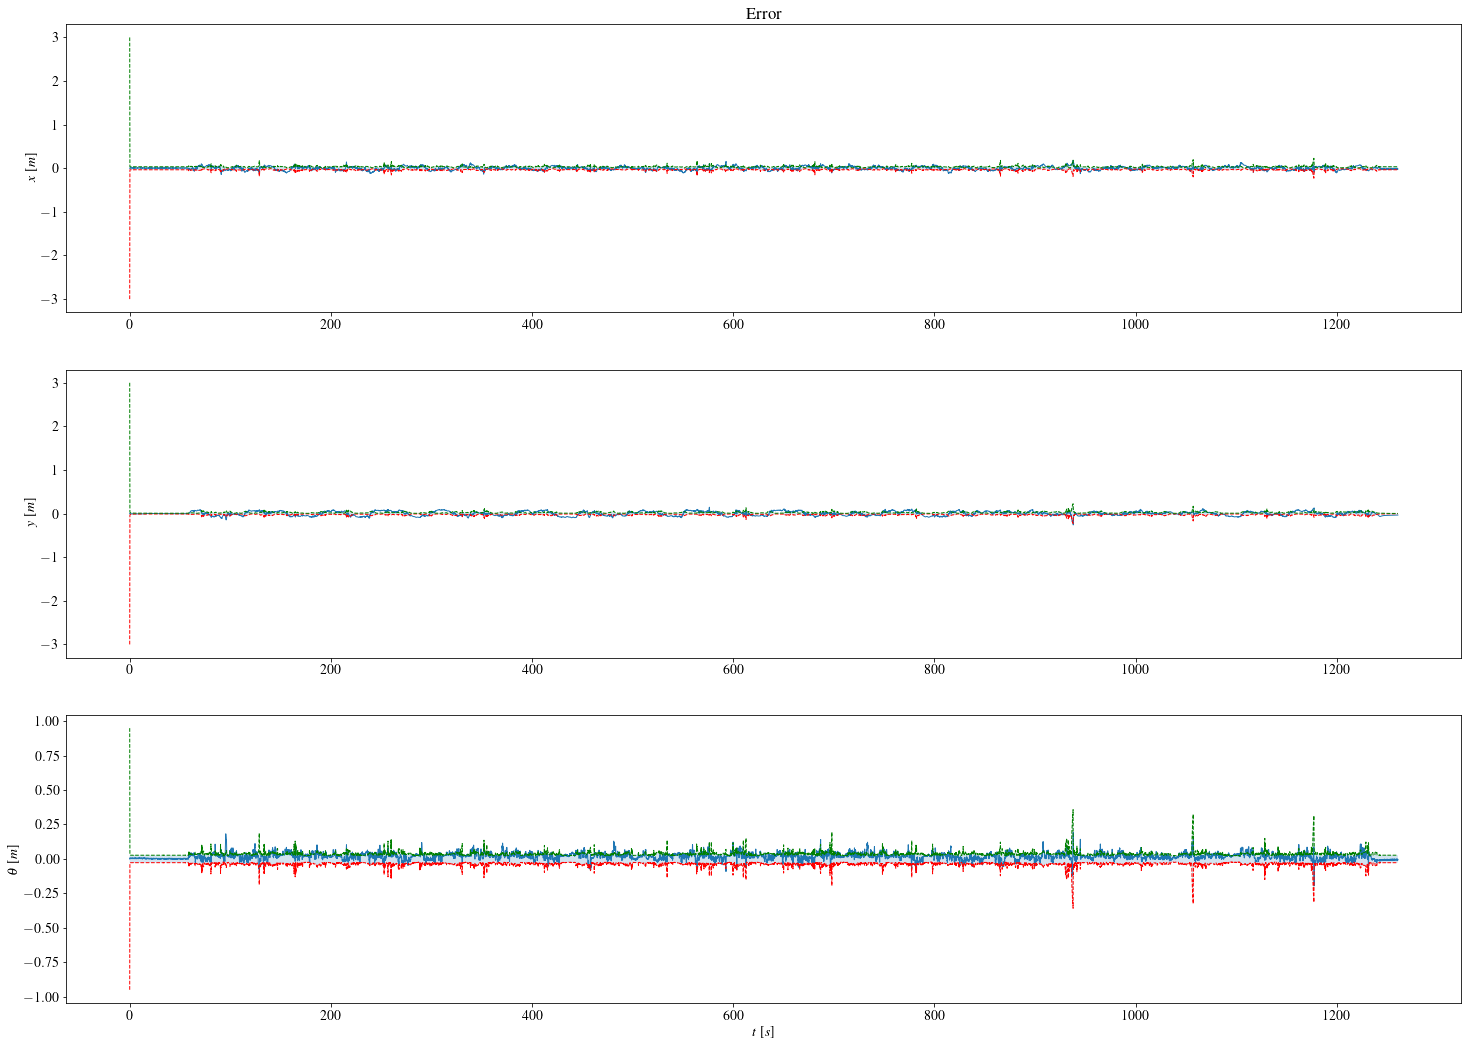

In [5]:
wrap_to_pi = lambda th: (th + np.pi) % (2 * np.pi) - np.pi

x_hat = []
x_cov_hat = []

# initial state
x_hat.append(x0)
x_cov_hat.append(x0_cov)

# filter update
for k in range(1, K):
    print(f"EKF: step {k} - {k / K * 100:4.2f}%", end="\r")

    xkm1 = x_hat[k - 1]
    xkm1_cov = x_cov_hat[k - 1]

    # prediction
    xk_pred = MotionError.f(xkm1, v[k], dt)
    xk_cov_pred = (
        MotionError.F(xkm1, v[k], dt) @ xkm1_cov @ MotionError.F(xkm1, v[k], dt).T
        + MotionNoise.W(xkm1, dt) @ v_cov @ MotionNoise.W(xkm1, dt).T
    )
    xk_cov_pred = 0.5 * (xk_cov_pred + xk_cov_pred.T)

    # correction
    rk = y[k, :, 0].squeeze()
    obs_idx = np.argwhere(np.logical_and(rk > 0, rk < rmax)).reshape(-1)
    if len(obs_idx) > 0:
        J = len(obs_idx)
        yk = np.zeros((2 * J, 1))
        gk = np.zeros((2 * J, 1))
        Gk = np.zeros((2 * J, 3))
        Rk = np.eye(2 * J)
        for j, idx in enumerate(obs_idx):
            yk[2 * j : 2 * j + 2] = y[k, idx]
            gk[2 * j : 2 * j + 2] = ObservationError.g(xk_pred, d, l[idx])
            Gk[2 * j : 2 * j + 2] = ObservationError.G(xk_pred, d, l[idx])
            Rk[2 * j : 2 * j + 2, 2 * j : 2 * j + 2] = (
                ObservationNoise.W() @ r_cov @ ObservationNoise.W().T
            )

        Kk = xk_cov_pred @ Gk.T @ npla.inv(Gk @ xk_cov_pred @ Gk.T + Rk)

        obs_err = yk - gk
        obs_err[range(1, 2 * J, 2)] = wrap_to_pi(obs_err[range(1, 2 * J, 2)])

        xk = xk_pred + Kk @ obs_err
        xk_cov = xk_cov_pred - Kk @ Gk @ xk_cov_pred
        xk_cov = 0.5 * (xk_cov + xk_cov.T)
    else:
        xk = xk_pred
        xk_cov = xk_cov_pred

    x_hat.append(xk)
    x_cov_hat.append(xk_cov)

x_hat = np.array(x_hat)
x_cov_hat = np.array(x_cov_hat)
x_std_hat = np.array([np.sqrt(np.diag(p)) for p in x_cov_hat])
plot(t, x_hat, x_std_hat, x_true)

ekf_x_hat = x_hat
ekf_x_std_hat = x_std_hat

## EKF via MAP (Not Exactly the Same)

average e^2: [0.00066564 0.00071171 0.00061152]


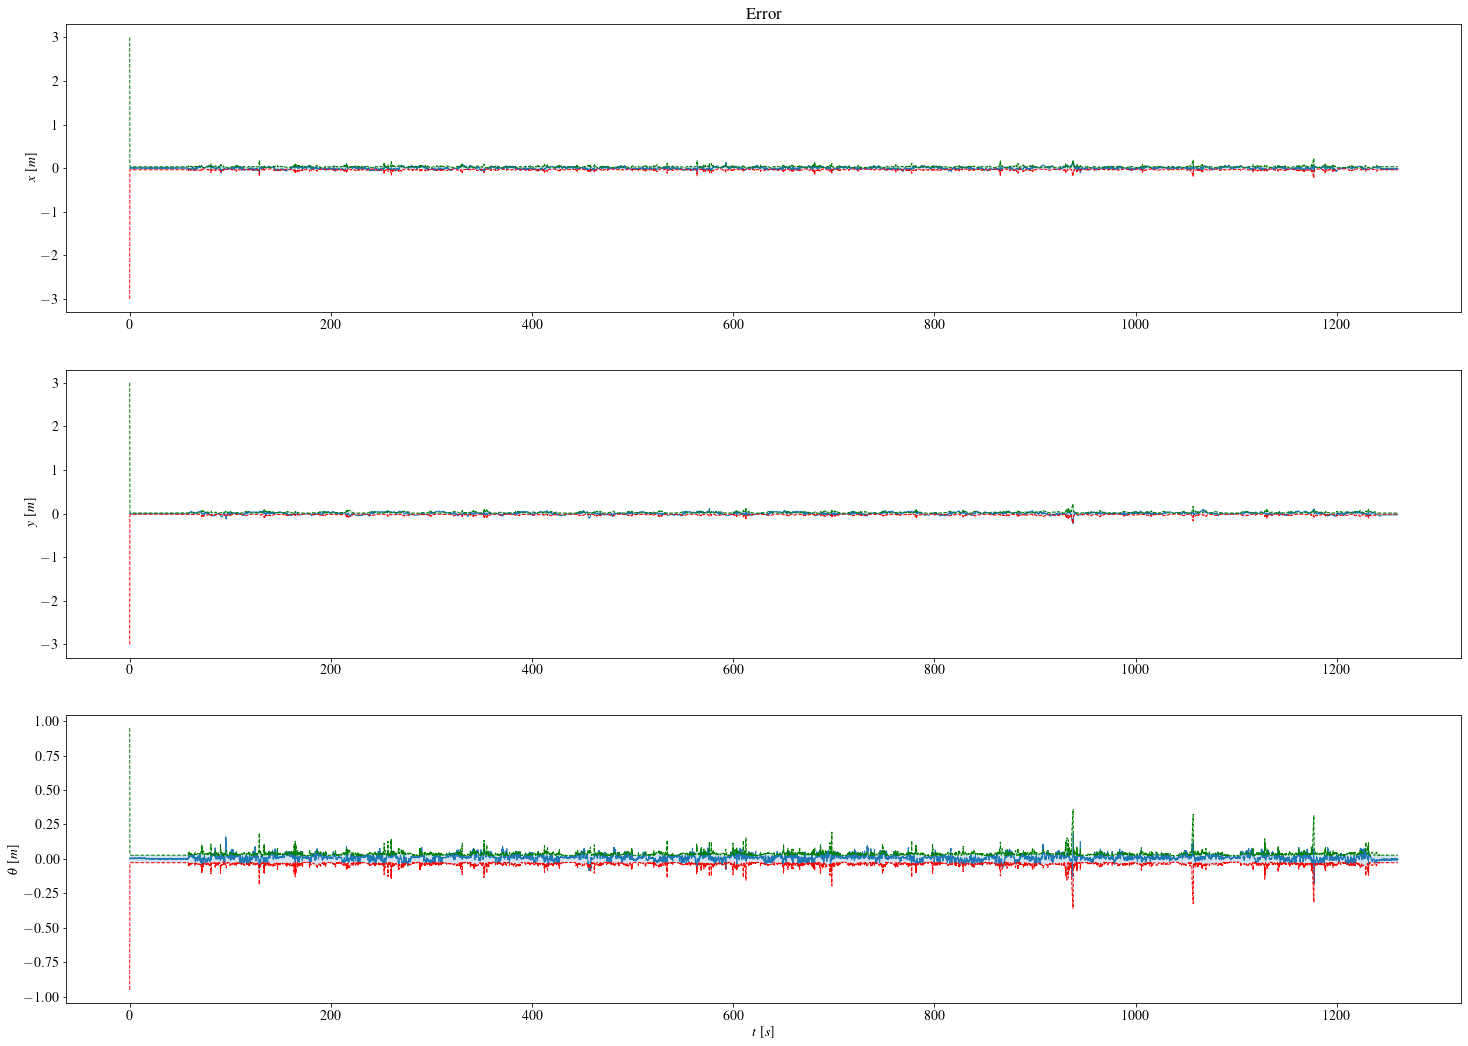

In [6]:
wrap_to_pi = lambda th: (th + np.pi) % (2 * np.pi) - np.pi

x_hat = []
x_cov_hat = []

# initial state
x_hat.append(x0)
x_cov_hat.append(x0_cov)

# filter update
for k in range(1, K):
    print(f"EKF: step {k} - {k / K * 100:4.2f}%", end="\r")

    # optimization problem
    opt_prob = problem.OptimizationProblem()

    # state (linear problem, initial value does not matter)
    xkm1_var = vspace.VSpaceStateVar(np.copy(x_hat[k - 1]))
    xk_var = vspace.VSpaceStateVar(np.copy(MotionError.f(x_hat[k - 1], v[k], dt)))
    opt_prob.add_state_var(xkm1_var, xk_var)

    # xkm1 prior
    xkm1 = x_hat[k - 1]
    xkm1_cov = x_cov_hat[k - 1]
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(xkm1_cov)
    error_func = vspace.vspace_error(xkm1_var, xkm1)
    opt_prob.add_cost_term(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

    # motion prior
    loss_func = problem.L2LossFunc()
    noise_model = problem.DynamicNoiseModel(MotionNoise(xkm1_var, v_cov, dt))
    error_func = MotionError(xk_var, xkm1_var, v[k], dt)
    opt_prob.add_cost_term(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

    # observation
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(r_cov)
    rk = y[k, :, 0].squeeze()
    obs_idx = np.argwhere(np.logical_and(rk > 0, rk < rmax)).reshape(-1)
    for j, idx in enumerate(obs_idx):
        error_func = ObservationError(xk_var, y[k, idx], d, l[idx])
        opt_prob.add_cost_term(
            problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
        )

    optimizer = solver.GaussNewtonSolver(opt_prob, max_iterations=1)
    optimizer.optimize()
    covariance = solver.Covariance(opt_prob)

    x_hat.append(xk_var.value)
    x_cov_hat.append(covariance.query(xk_var))

x_hat = np.array(x_hat)
x_cov_hat = np.array(x_cov_hat)
x_std_hat = np.array([np.sqrt(np.diag(p)) for p in x_cov_hat])
plot(t, x_hat, x_std_hat, x_true)

ekfmap_x_hat = x_hat
ekfmap_x_std_hat = x_std_hat
# assert np.allclose(ekfmap_x_std_hat, ekf_x_std_hat)  # not exactly the same
# assert np.allclose(ekfmap_x_hat, ekf_x_hat)          # not exactly the same

## Sliding-Window Filter

average e^2: [0.00066497 0.00071223 0.00061157]


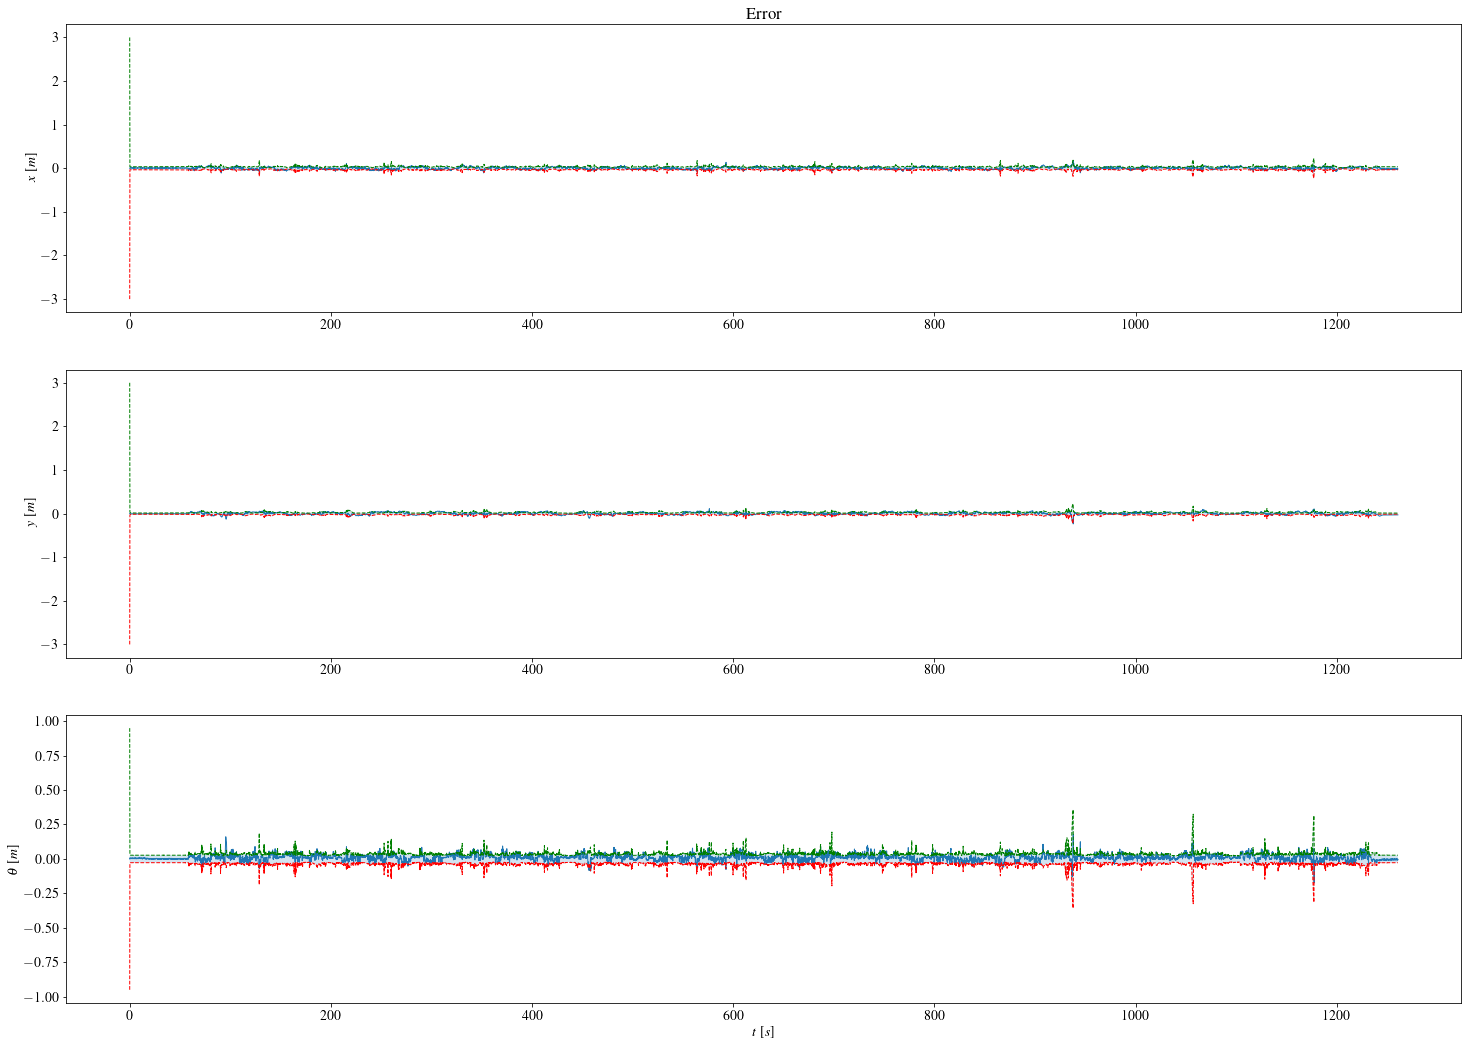

In [7]:
x_hat = []
x_cov_hat = []

# create a sliding window filter
swfilter = problem.SlidingWindowFilter()

# add initial variable
x_var = [vspace.VSpaceStateVar(np.copy(x0), name="x0")]
swfilter.add_variable(x_var[0])

# initial state prior
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(x0_cov)
error_func = vspace.vspace_error(x_var[0], x0)
swfilter.add_cost_term(
    problem.WeightedLeastSquareCostTerm(
        error_func, noise_model, loss_func, name=f"x{0}-prior"
    )
)

# initial state
x_hat.append(x0)
x_cov_hat.append(x0_cov)

# filter update
for k in range(1, K):
    print(f"SWF: step {k} - {k / K * 100:4.2f}%", end="\r")

    # add a new variable
    x_var.append(
        vspace.VSpaceStateVar(
            np.copy(MotionError.f(x_hat[k - 1], v[k], dt)), name=f"x{k}"
        )
    )
    swfilter.add_variable(x_var[k])

    # state (linear problem, initial value does not matter)
    xkm1_var, xk_var = x_var[k - 1], x_var[k]

    # motion prior
    loss_func = problem.L2LossFunc()
    noise_model = problem.DynamicNoiseModel(MotionNoise(xkm1_var, v_cov, dt))
    error_func = MotionError(xk_var, xkm1_var, v[k], dt)
    swfilter.add_cost_term(
        problem.WeightedLeastSquareCostTerm(
            error_func, noise_model, loss_func, name=f"x{k-1}-x{k}-motion"
        )
    )

    # observation
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(r_cov)
    rk = y[k, :, 0].squeeze()
    obs_idx = np.argwhere(np.logical_and(rk > 0, rk < rmax)).reshape(-1)
    for j, idx in enumerate(obs_idx):
        error_func = ObservationError(xk_var, y[k, idx], d, l[idx])
        swfilter.add_cost_term(
            problem.WeightedLeastSquareCostTerm(
                error_func, noise_model, loss_func, name=f"x{k}-observation"
            )
        )

    # marginalize before optimizing
    swfilter.marginalize_variable(xkm1_var)

    optimizer = solver.GaussNewtonSolver(swfilter, max_iterations=1)
    optimizer.optimize()
    covariance = solver.Covariance(swfilter)

    x_hat.append(xk_var.value)
    x_cov_hat.append(covariance.query(xk_var))

x_hat = np.array(x_hat)
x_cov_hat = np.array(x_cov_hat)
x_std_hat = np.array([np.sqrt(np.diag(p)) for p in x_cov_hat])
plot(t, x_hat, x_std_hat, x_true)

swf_x_hat = x_hat
swf_x_std_hat = x_std_hat
# assert np.allclose(ekfmap_x_hat, swf_x_hat)  # not exactly the same
# assert np.allclose(ekfmap_x_std_hat, swf_x_std_hat)  # not exactly the same